# Pytorch image classification on SparkXShards

Copyright 2016 The BigDL Authors.

SparkXshards in Orca allows users to process large-scale dataset using existing Python codes in a distributed and data-parallel fashion, as shown below. This notebook is an example of training an image classification model in PyTorch on Orca Estimtor and SparkXShard of images. 

It is adapted from [Pytorch CNN tutorial with cats and dogs](https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs) on [Kaggle Dogs vs. Cats data](https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data). 

In [1]:
# Use seaborn for some plots
!pip install torch torchvision

You should consider upgrading via the '/Users/guoqiong/opt/anaconda3/envs/py37tf2/bin/python -m pip install --upgrade pip' command.


In [ ]:
# import necessary libraries
from bigdl.orca.data.shard import SparkXShards
from bigdl.orca.learn.pytorch import Estimator
from bigdl.orca.learn.metrics import Accuracy
from bigdl.orca import init_orca_context, stop_orca_context
import bigdl.orca.data.image
from torch import nn
import torch.optim as optim
from torchvision import transforms
import numpy as np

Start an OrcaContext and give a bit more memory.

In [ ]:
sc = init_orca_context(cluster_mode="local", cores=4, memory="8g")

##  Load images into SparkXShards in parallel

Load data into data_shards, it is a SparkXshards that can be operated on in parallel. Here each record is a tuple of (image: PIL.Image.Image and label), label is retrieved from get_label function of filename.

In [4]:
input_dir = '../dogs-vs-cats/'

def get_label(file_name):
    label = [1] if 'dog' in file_name.split('/')[-1] else [0]
    return label

data_shards = bigdl.orca.data.image.read_images_spark(input_dir, get_label)

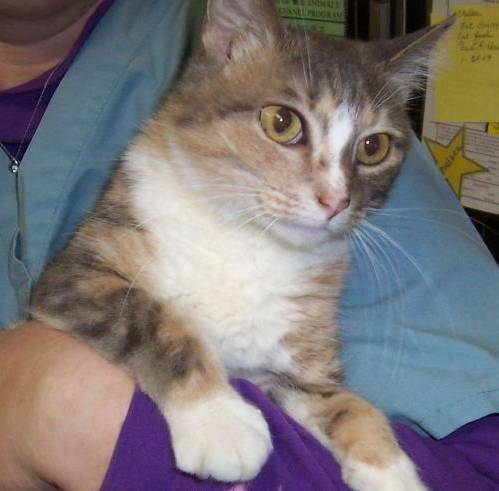

In [5]:
# take a look at the data
image, label = data_shards.first()
display(image)

In [6]:
# see the num of partitions of data_shards
data_shards.num_partitions()


4

## Transformation of the images

Define a train_transform function directly using methods of torchvision transforms 

In [7]:
def train_transform(im):
    features = im[0]
    features = transforms.Resize((224, 224))(features)
    features = transforms.RandomResizedCrop(224)(features)
    features = transforms.RandomHorizontalFlip()(features)
    features = transforms.ToTensor()(features)
    features = features.numpy()
    return features, im[1]

In [8]:
data_shards = data_shards.transform_shard(train_transform)

Stack elements of each partition into an ndarray of features and labels for efficient training

In [9]:
data_shards = data_shards.stack_feature_labels()

## The model

Build the U-Net model model as usual. Here, model is adapted from a [kaggle example] (https://www.kaggle.com/code/reukki/pytorch-cnn-tutorial-with-cats-and-dogs).

In [10]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(3 * 3 * 64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.act = nn.Sigmoid()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        out = self.act(out)
        return out


define a model_creator for Orca Estimator and show the summary of model structure

In [11]:
def model_creator(config):
    model = Cnn()
    model.train()
    print(model)
    return model

define the loss function, optimizer

In [12]:
criterion = nn.BCELoss()

def optimizer_creator(model, config):
    optimizer = optim.Adam(params=model.parameters(), lr=0.001)
    return optimizer

define an Orca Estimator and train the model

In [13]:
orca_estimator = Estimator.from_torch(model=model_creator,
                                      optimizer=optimizer_creator,
                                      loss=criterion,
                                      metrics=[Accuracy()],
                                      backend="spark")

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (re

In [ ]:
orca_estimator.fit(data=data_shards, epochs=10, batch_size=32)

In [15]:
stop_orca_context()

Stopping orca context
